# Load Libraries

In [2]:
import os
import pandas as pd
import geopandas as gpd
import jax
import jax.nn as nn
from jax import lax, random
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as np
import numpyro
import pickle
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, RenyiELBO
import arviz as az
import sys
from pyprojroot import here
import time
sys.path.append(str(here() / "simulation study" / "src"))
# Import our modular components
from kernels import exp_sq_kernel, M_g
from loader_jkt import load_data
from gp import gp_aggr
from vae import vae_model, vae_guide, vae_decoder
from plotting import plot_process, plot_incidence_map
import matplotlib.pyplot as plt
from numpyro.infer import NUTS, MCMC, Predictive, init_to_median, init_to_uniform, init_to_sample, init_to_mean, init_to_value

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MCMC Inference

In [3]:
# ------------------- Func for Agg VAE Prev ------------------- #
def prev_model_vae_aggr(config=None):

    if config is None:
        config = {}

    # Set defaults
    x = config.get('x', None)
    gp_kernel = config.get('gp_kernel', exp_sq_kernel)
    noise = config.get('noise', 1e-4)
    jitter = config.get('jitter', 1e-4)
    M_lo = config.get('M_lo', None)
    M_hi = config.get('M_hi', None)
    kernel_length_prior = config.get('kernel_length', dist.InverseGamma(4, 1))
    kernel_var_prior = config.get('kernel_var', dist.LogNormal(0, 0.1))
    pop_density = config.get('pop_density', None)
    urban_frac = config.get('urban_frac', None)
    hdi_index = config.get('hdi_index', None)
    count = config.get("count", None)

     # Total cases: pass in low prev counts, mask high prev ones as NaN
    count_mask = ~jnp.isnan(count)

    total_population = config.get('total_population', None)
    is_prior_pred = config.get('prior_pred', False)
    out_dims = config.get('out_dims', 6)
    # GP
    config_gp = config.copy()
    config_gp['x'] = x
    config_gp['gp_kernel'] = gp_kernel
    config_gp['noise'] = noise
    config_gp['jitter'] = jitter
    config_gp['M_lo'] = M_lo
    config_gp['M_hi'] = M_hi
    config_gp['kernel_length'] = kernel_length_prior
    config_gp['kernel_var'] = kernel_var_prior
    # Call gp_aggr
    decoder_params = config["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) #Instantiate decoder
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))
    s = numpyro.sample("sigma1", dist.HalfNormal(200))

    vae = numpyro.deterministic("vae", s * vae_aggr)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(100, 10))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    # Linear predictor
    # lp = numpyro.deterministic("lp", (b0 +
    #                                   aggr_gp +
    #                                   b_pop_density * pop_density +
    #                                   b_hdi * hdi_index +
    #                                   b_urban * urban_frac))  #
    lp = numpyro.deterministic("lp", nn.softplus(b0 +
                                      vae +
                                      b_pop_density * pop_density +
                                      b_hdi * hdi_index +
                                      b_urban * urban_frac))


    sigma = numpyro.sample("sigma", dist.HalfNormal(5))

    # Full predictions (no masking)
    full_pred_cases = numpyro.sample(
        "full_pred_cases",
        dist.Normal(lp, sigma))

    # Observed only where count is available
    with numpyro.handlers.mask(mask=count_mask):
        numpyro.sample(
            "pred_cases",  # not used for return
            dist.Normal(lp, sigma),
            obs=None if is_prior_pred else count)

    # Store full predictions
    numpyro.deterministic("pred_cases_out", full_pred_cases)


## Load all the MCMC objects for all the years


In [4]:
# for 2020, 2021, 2022, 2023
with open("../model weights/aggVAEPrev/mcmc_jkt_2020_78min_prob0.85_treedepth20.pkl", "rb") as f_1:
    mcmc_2020 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2021_78min_prob0.85_treedepth20.pkl", "rb") as f_2:
    mcmc_2021 = pickle.load(f_2)

with open("../model weights/aggVAEPrev/mcmc_jkt_2022_567min_z40_prob0.9_treedepth18.pkl", "rb") as f_3:
    mcmc_2022 = pickle.load(f_3)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_59min_z40_prob0.95_treedepth15.pkl", "rb") as f_4:
    mcmc_2023 = pickle.load(f_4)


In [5]:
n_lo = 1
n_hi = 5

# Yearly Inferences

### 2023 Inference

In [6]:
df_2023 = pd.read_csv("../data/processed/df_hi_jkt_2023_aggVAE_preds.csv")

In [7]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2023['geometry'] = df_2023['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2023 = gpd.GeoDataFrame(df_2023, geometry='geometry', crs="EPSG:4326")

In [8]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2023.get_samples()
print(mcmc_2023.print_summary())


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     94.14     13.29     95.49     76.55    111.39      3.10      1.61
             b_hdi      0.00      0.87     -0.00     -1.51      1.47   1980.44      1.00
     b_pop_density      0.66      1.41      0.50     -1.15      2.53      3.09      1.63
           b_urban     -0.11      0.88     -0.40     -1.55      1.38     35.33      1.05
full_pred_cases[0]   1561.76      6.10   1560.95   1552.70   1571.04   2266.47      1.00
full_pred_cases[1]    284.49    133.42    253.29    125.91    534.28     10.63      1.14
full_pred_cases[2]    151.54    127.42     94.80    -11.04    335.73     18.67      1.09
full_pred_cases[3]    341.46    139.18    315.28    174.94    599.55     11.18      1.13
full_pred_cases[4]    452.43    145.50    437.44    294.28    703.99      8.05      1.18
full_pred_cases[5]    428.04    142.87    413.72    279.87    656.04      6.48      1.22
             sigma  

In [9]:
ss = numpyro.diagnostics.summary(mcmc_2023.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1260
Average ESS for all aggVAE-low effects : 1173
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 1278
Max r_hat for all aggVAE-high : 1.0


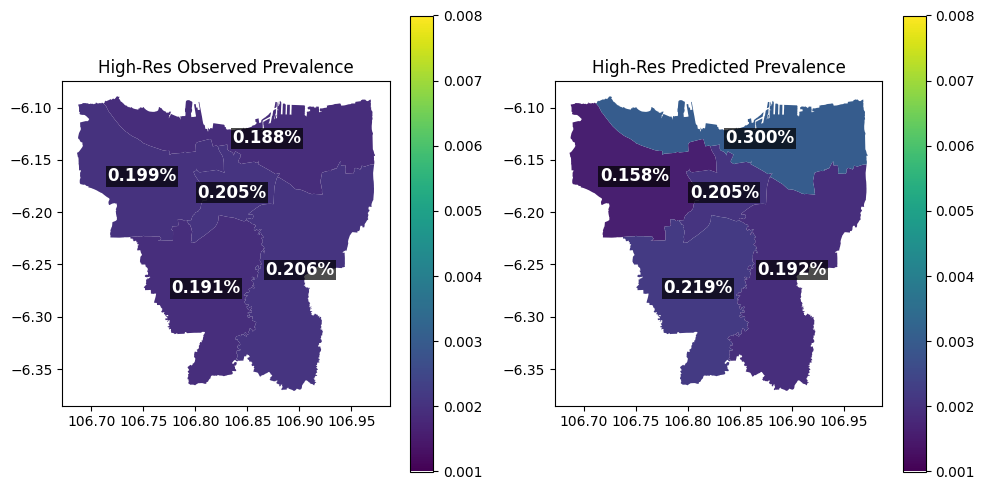

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2023, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2023, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### 2022 Inference

In [11]:
df_2022 = pd.read_csv("../data/processed/df_hi_jkt_2022_aggVAE_preds.csv")

In [12]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2022['geometry'] = df_2022['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry='geometry', crs="EPSG:4326")

In [13]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2022.get_samples()
print(mcmc_2022.print_summary())


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.72      8.67     98.10     85.09    114.41       nan      1.01
             b_hdi     -0.07      0.86     -0.28     -1.43      1.51    904.59      1.01
     b_pop_density      0.47      1.16      0.48     -1.25      1.80      4.09      1.37
           b_urban     -0.08      0.89     -0.39     -1.39      1.60     37.05      1.04
full_pred_cases[0]   2112.72      6.29   2112.35   2103.26   2123.13   2145.95      1.00
full_pred_cases[1]    376.25    138.00    348.80    198.18    612.92     22.35      1.09
full_pred_cases[2]    177.32    152.57    151.07     -7.99    399.83      6.58      1.22
full_pred_cases[3]    453.48    149.47    437.87    277.01    711.55     11.43      1.13
full_pred_cases[4]    612.62    151.25    594.74    424.93    847.68     17.56      1.10
full_pred_cases[5]    585.21    126.98    565.96    393.14    751.71    404.43      1.01
             sigma  

In [14]:
ss = numpyro.diagnostics.summary(mcmc_2022.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 22
Average ESS for all aggVAE-low effects : 23
Max r_hat for all aggVAE-low : 1.0700000524520874
Average ESS for all aggVAE-high effects : 22
Max r_hat for all aggVAE-high : 1.100000023841858


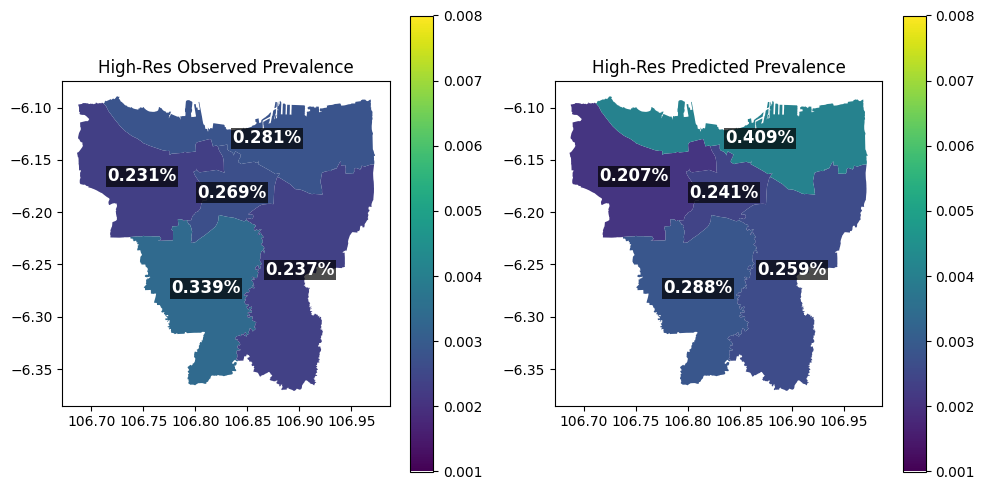

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2022, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2022, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### 2021 Inference

In [16]:
df_2021 = pd.read_csv("../data/processed/df_hi_jkt_2021_aggVAE_preds.csv")

In [17]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2021['geometry'] = df_2021['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry='geometry', crs="EPSG:4326")

In [18]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2021.get_samples()
print(mcmc_2021.print_summary())


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.97      9.92     99.78     83.42    116.03   3134.41      1.00
             b_hdi      0.10      1.01      0.11     -1.54      1.77   1149.65      1.00
     b_pop_density      0.12      1.03      0.13     -1.66      1.75   2105.43      1.00
           b_urban      0.11      1.03      0.08     -1.65      1.75    414.62      1.00
full_pred_cases[0]   1047.92      8.08   1047.89   1035.29   1061.32   1560.81      1.00
full_pred_cases[1]    254.39    125.29    257.48     68.67    497.88    306.74      1.01
full_pred_cases[2]    165.45    126.63    156.37    -13.52    343.82    307.95      1.01
full_pred_cases[3]    290.90    128.40    295.35     96.02    522.94    312.14      1.01
full_pred_cases[4]    364.21    126.52    368.06    167.57    572.16    347.69      1.01
full_pred_cases[5]    351.31    122.24    346.75    179.09    568.27    413.81      1.00
             sigma  

In [19]:
ss = numpyro.diagnostics.summary(mcmc_2021.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 505
Average ESS for all aggVAE-low effects : 449
Max r_hat for all aggVAE-low : 1.0199999809265137
Average ESS for all aggVAE-high effects : 516
Max r_hat for all aggVAE-high : 1.0199999809265137


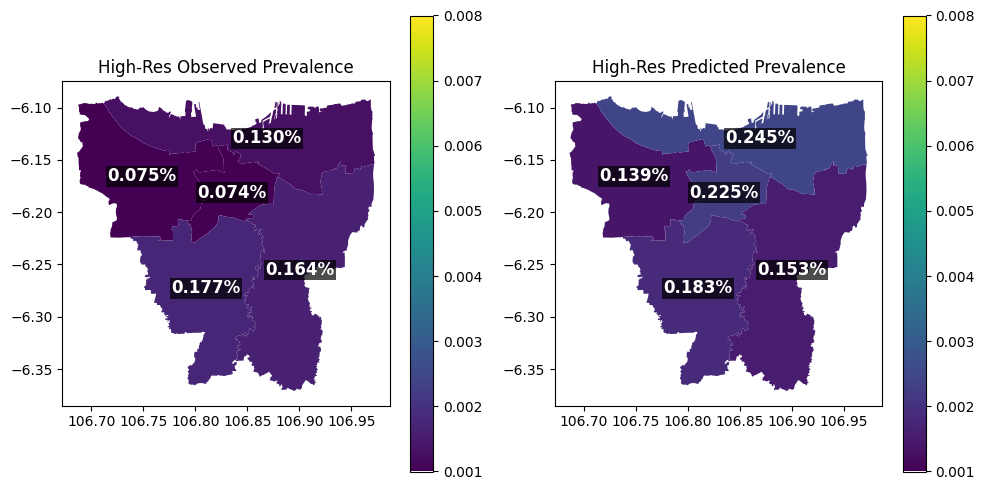

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2021, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2021, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### 2020 Inference

In [21]:
df_2020 = pd.read_csv("../data/processed/df_hi_jkt_2020_aggVAE_preds.csv")

In [22]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2020['geometry'] = df_2020['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry='geometry', crs="EPSG:4326")

In [23]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2020.get_samples()
print(mcmc_2020.print_summary())


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.20      9.68    100.50     85.43    117.30   2867.23      1.00
             b_hdi      0.03      0.99      0.02     -1.58      1.66   1161.22      1.00
     b_pop_density      0.14      0.98      0.13     -1.57      1.60    833.38      1.01
           b_urban      0.11      1.02      0.12     -1.48      1.85    883.30      1.01
full_pred_cases[0]   1217.31      8.32   1217.21   1203.62   1229.71   1908.75      1.00
full_pred_cases[1]    267.76    132.47    267.42     36.46    467.38    377.31      1.02
full_pred_cases[2]    162.08    132.34    152.04    -10.87    345.49    430.28      1.02
full_pred_cases[3]    309.39    137.69    311.11     72.03    512.51    316.53      1.02
full_pred_cases[4]    397.71    137.44    400.11    134.48    583.66    276.42      1.03
full_pred_cases[5]    387.74    129.27    375.47    171.79    578.67    504.53      1.01
             sigma  

In [24]:
ss = numpyro.diagnostics.summary(mcmc_2020.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 741
Average ESS for all aggVAE-low effects : 765
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 736
Max r_hat for all aggVAE-high : 1.0099999904632568


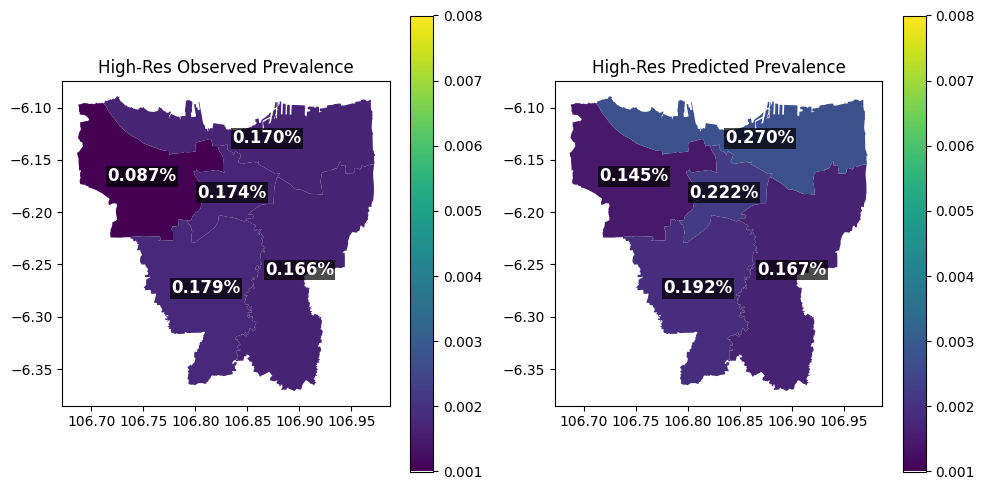

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2020, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2020, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()